# Problem 1: Y-Chromosome Concentration Modeling & Analysis

## Overview

**Objective**: Model how fetal Y-chromosome concentration depends on gestational age and maternal BMI, and test statistical significance.

**Prerequisites**: Clean data from `00_data_preprocessing.ipynb`

**Analysis Plan**:
1. Load preprocessed data
2. Exploratory Data Analysis (EDA) 
3. Baseline OLS regression modeling
4. Model diagnostics and alternatives
5. Effect visualization and interpretation
6. Robustness validation

---

## Load Preprocessed Data

**Note**: Data cleaning and preprocessing completed in `00_data_preprocessing.ipynb` following detailed business rules.


In [2]:
# Import libraries for modeling and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pathlib import Path

# Configure display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

# Load preprocessed data from previous notebook
print("📊 Loading clean dataset for Problem 1 analysis...")
print("   (Preprocessing rules applied in 00_data_preprocessing.ipynb)")

# Load cleaned data from CSV file (generated by preprocessing notebook)
clean_data_path = Path("../../output/data/clean_dataset_prob1.csv")

if clean_data_path.exists():
    df_clean = pd.read_csv(clean_data_path)
    print(f"✅ Clean dataset loaded from {clean_data_path}")
    print(f"   Dataset shape: {df_clean.shape}")
    print(f"   Variables: {list(df_clean.columns)}")
    
    # Display summary statistics
    print(f"\n📊 Dataset Summary:")
    print(f"   Samples: {len(df_clean)}")
    print(f"   Gestational weeks range: {df_clean['weeks'].min():.1f} - {df_clean['weeks'].max():.1f}")
    print(f"   BMI range: {df_clean['BMI'].min():.1f} - {df_clean['BMI'].max():.1f}")
    print(f"   Y concentration range: {df_clean['Y_concentration'].min():.6f} - {df_clean['Y_concentration'].max():.6f}")
    print(f"   Samples ≥ 4% threshold: {(df_clean['Y_concentration'] >= 0.04).sum()} ({(df_clean['Y_concentration'] >= 0.04).mean()*100:.1f}%)")
    
else:
    print(f"❌ Clean dataset not found at {clean_data_path}")
    print("   Please run 00_data_preprocessing.ipynb first to generate the cleaned data.")
    raise FileNotFoundError("Clean dataset file not found. Run preprocessing notebook first.")


📊 Loading clean dataset for Problem 1 analysis...
   (Preprocessing rules applied in 00_data_preprocessing.ipynb)
✅ Clean dataset loaded from ../../output/data/clean_dataset_prob1.csv
   Dataset shape: (555, 4)
   Variables: ['patient_code', 'weeks', 'BMI', 'Y_concentration']

📊 Dataset Summary:
   Samples: 555
   Gestational weeks range: 11.0 - 24.9
   BMI range: 26.6 - 46.9
   Y concentration range: 0.010004 - 0.234218
   Samples ≥ 4% threshold: 483 (87.0%)


# Problem 1: Y-Chromosome Concentration Modeling

## Clarify Targets & Fields

**Objective**: Model how fetal Y-chromosome concentration depends on gestational age and maternal BMI, and test the statistical significance of these relationships.

**Key Question**: How does Y-chromosome concentration vary with gestational weeks and maternal BMI, particularly in relation to the 4% reliability threshold for male fetus detection?

**Statistical Goal**: Establish a quantitative relationship model and perform significance testing to determine if gestational age and BMI are significant predictors of Y-chromosome concentration in male fetuses.

### Key Columns for Analysis (Actual Column Names)
- **检测孕周**: Gestational weeks during testing → primary predictor (convert to decimal weeks)
- **孕妇BMI**: Maternal BMI index → primary predictor  
- **Y染色体浓度**: Y chromosome concentration (proportion of free fetal DNA) → response variable (male fetuses only)
- **Y染色体的Z值**: Y chromosome Z-score → alternative/validation measure
- **孕妇代码**: Patient code → for repeated measures if applicable

### Key Assumptions
1. Analysis restricted to 10-25 weeks gestational age (typical NIPT window)
2. Y-chromosome concentration ≥4% considered reliable for male fetus detection
3. Analysis limited to male fetuses (Y染色体浓度 non-null, as female fetuses have empty values)
4. Initial assumption of linear relationships, with non-linear terms if needed


## Step 3: EDA & Linearity Check

### Goals:
1. Create scatter plots of Y concentration vs. weeks and BMI
2. Calculate correlations (Pearson and Spearman)
3. Assess linearity assumptions
4. Check for patterns suggesting non-linear relationships


📊 Creating scatter plots for Y concentration vs predictors...


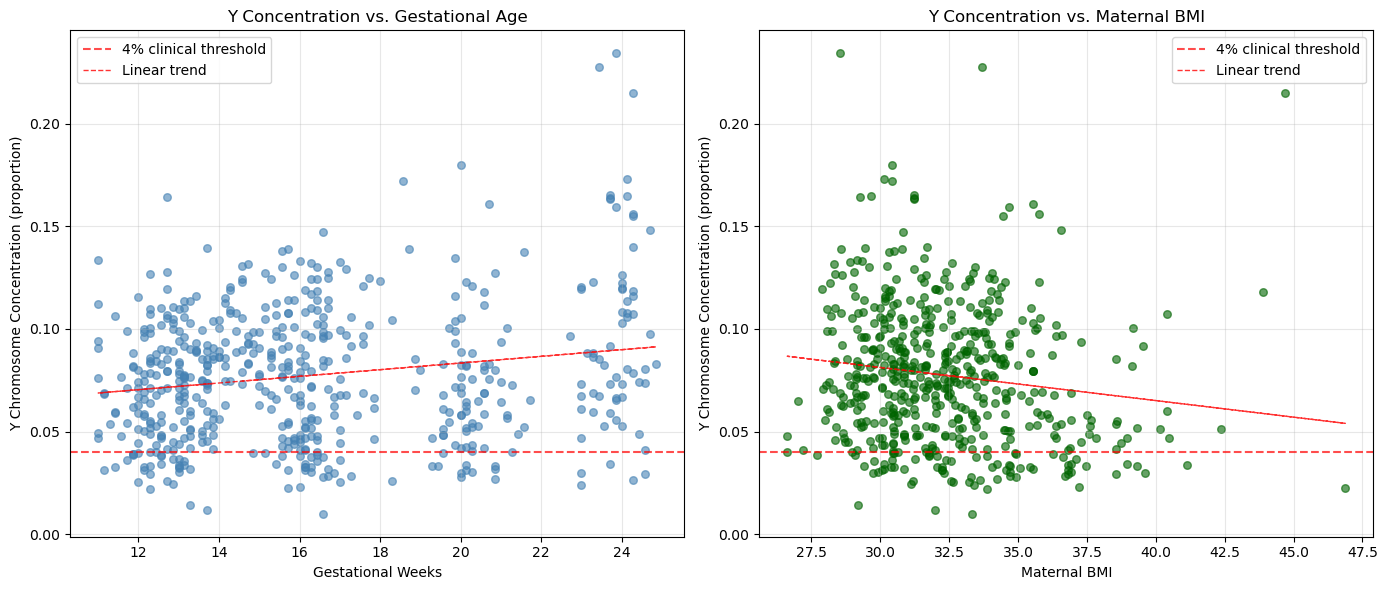

✅ Scatter plots saved:
   - ../../output/figures/p1_scatter_weeks_vs_V.png
   - ../../output/figures/p1_scatter_BMI_vs_V.png


In [3]:
# Create scatter plots for Step 3: EDA & Linearity Check
print("📊 Creating scatter plots for Y concentration vs predictors...")

# Ensure output directory exists
output_dir = Path("../../output/figures")
output_dir.mkdir(parents=True, exist_ok=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Y concentration vs. gestational weeks
ax1.scatter(df_clean['weeks'], df_clean['Y_concentration'], alpha=0.6, s=30, color='steelblue')
ax1.axhline(y=0.04, color='red', linestyle='--', alpha=0.7, label='4% clinical threshold')
ax1.set_xlabel('Gestational Weeks')
ax1.set_ylabel('Y Chromosome Concentration (proportion)')
ax1.set_title('Y Concentration vs. Gestational Age')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add trend line
z1 = np.polyfit(df_clean['weeks'], df_clean['Y_concentration'], 1)
p1 = np.poly1d(z1)
ax1.plot(df_clean['weeks'], p1(df_clean['weeks']), "r--", alpha=0.8, linewidth=1, label='Linear trend')
ax1.legend()

# Y concentration vs. BMI
ax2.scatter(df_clean['BMI'], df_clean['Y_concentration'], alpha=0.6, s=30, color='darkgreen')
ax2.axhline(y=0.04, color='red', linestyle='--', alpha=0.7, label='4% clinical threshold')
ax2.set_xlabel('Maternal BMI')
ax2.set_ylabel('Y Chromosome Concentration (proportion)')
ax2.set_title('Y Concentration vs. Maternal BMI')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add trend line
z2 = np.polyfit(df_clean['BMI'], df_clean['Y_concentration'], 1)
p2 = np.poly1d(z2)
ax2.plot(df_clean['BMI'], p2(df_clean['BMI']), "r--", alpha=0.8, linewidth=1, label='Linear trend')
ax2.legend()

plt.tight_layout()

# Save plots
weeks_plot_path = output_dir / "p1_scatter_weeks_vs_V.png"
bmi_plot_path = output_dir / "p1_scatter_BMI_vs_V.png"

plt.savefig(weeks_plot_path, dpi=300, bbox_inches='tight')
plt.savefig(bmi_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Scatter plots saved:")
print(f"   - {weeks_plot_path}")
print(f"   - {bmi_plot_path}")


In [4]:
# Calculate correlations for Step 3: Statistical Analysis
print("📊 Computing correlation analysis...")

# Pearson correlations (linear relationships)
pearson_weeks = pearsonr(df_clean['weeks'], df_clean['Y_concentration'])
pearson_bmi = pearsonr(df_clean['BMI'], df_clean['Y_concentration'])

# Spearman correlations (monotonic relationships)
spearman_weeks = spearmanr(df_clean['weeks'], df_clean['Y_concentration'])
spearman_bmi = spearmanr(df_clean['BMI'], df_clean['Y_concentration'])

# Create correlation summary
correlations_df = pd.DataFrame({
    'Variable': ['Gestational Weeks', 'Maternal BMI'],
    'Pearson_r': [pearson_weeks[0], pearson_bmi[0]],
    'Pearson_p': [pearson_weeks[1], pearson_bmi[1]],
    'Spearman_r': [spearman_weeks[0], spearman_bmi[0]], 
    'Spearman_p': [spearman_weeks[1], spearman_bmi[1]],
    'Significance': ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns' 
                    for p in [pearson_weeks[1], pearson_bmi[1]]]
})

print("\n📊 Correlation Analysis Results:")
print("=" * 80)
print(correlations_df.round(4))

# Ensure results directory exists
results_dir = Path("../../output/results")
results_dir.mkdir(parents=True, exist_ok=True)

# Save correlations
correlations_path = results_dir / "p1_correlations.csv"
correlations_df.to_csv(correlations_path, index=False)
print(f"\n✅ Correlations saved to {correlations_path}")

# Interpret correlations
print("\n🔍 Correlation Interpretation:")
print(f"• Gestational Weeks: r = {pearson_weeks[0]:.4f} (p = {pearson_weeks[1]:.4f})")
if abs(pearson_weeks[0]) > 0.5:
    strength_weeks = "strong"
elif abs(pearson_weeks[0]) > 0.3:
    strength_weeks = "moderate"
else:
    strength_weeks = "weak"
direction_weeks = "positive" if pearson_weeks[0] > 0 else "negative"
print(f"  → {strength_weeks} {direction_weeks} linear relationship")

print(f"• Maternal BMI: r = {pearson_bmi[0]:.4f} (p = {pearson_bmi[1]:.4f})")
if abs(pearson_bmi[0]) > 0.5:
    strength_bmi = "strong"
elif abs(pearson_bmi[0]) > 0.3:
    strength_bmi = "moderate"
else:
    strength_bmi = "weak"
direction_bmi = "positive" if pearson_bmi[0] > 0 else "negative"
print(f"  → {strength_bmi} {direction_bmi} linear relationship")

print("\nNote: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")


📊 Computing correlation analysis...

📊 Correlation Analysis Results:
            Variable  Pearson_r  Pearson_p  Spearman_r  Spearman_p  \
0  Gestational Weeks     0.1844     0.0000      0.1145      0.0069   
1       Maternal BMI    -0.1378     0.0011     -0.1498      0.0004   

  Significance  
0          ***  
1           **  

✅ Correlations saved to ../../output/results/p1_correlations.csv

🔍 Correlation Interpretation:
• Gestational Weeks: r = 0.1844 (p = 0.0000)
  → weak positive linear relationship
• Maternal BMI: r = -0.1378 (p = 0.0011)
  → weak negative linear relationship

Note: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


📊 Completing Step 3: Distribution Analysis & Linearity Assessment


/tmp/ipykernel_810896/3877826360.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(box_data, labels=week_bins.cat.categories)


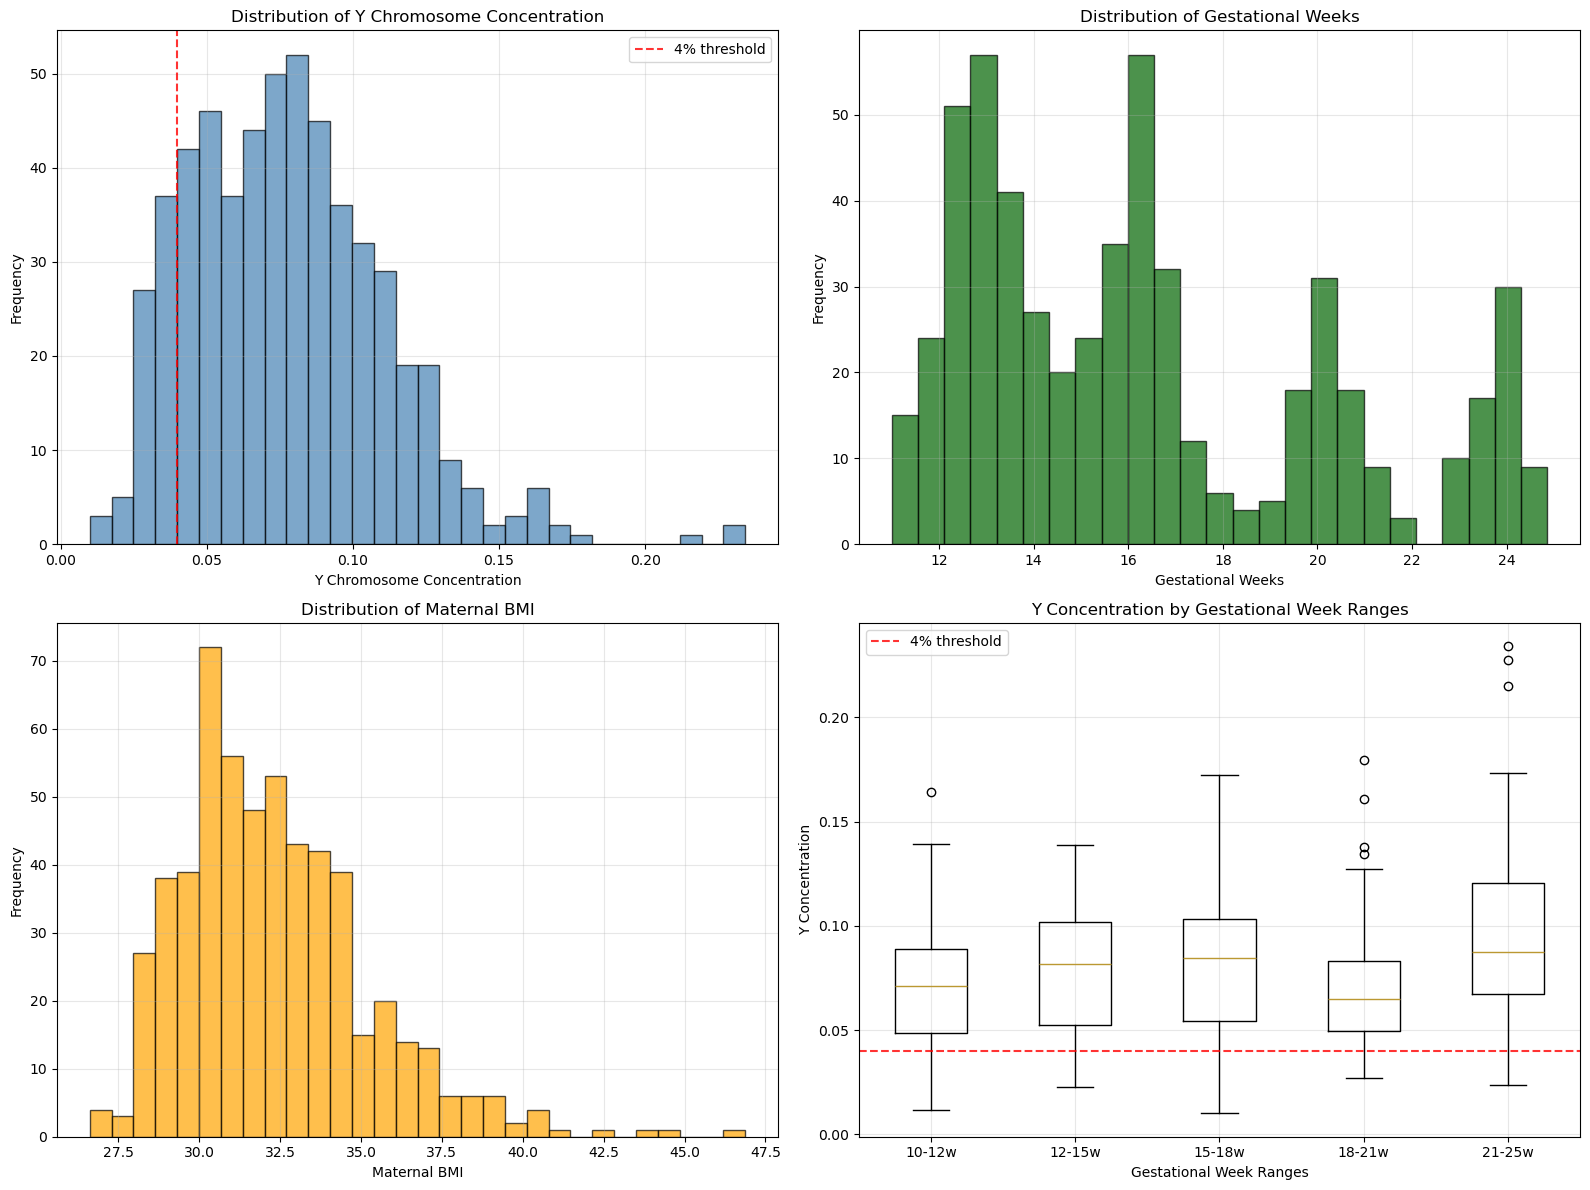


🔍 Linearity Assessment:


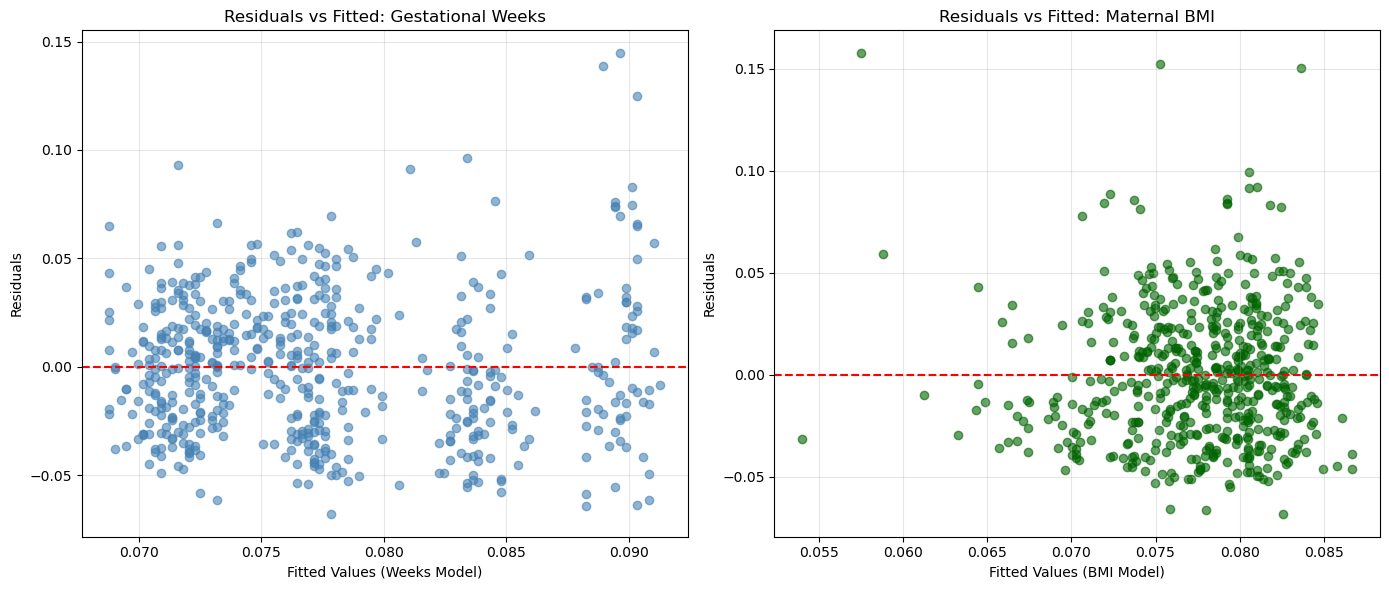


📊 Clinical Threshold Analysis:
        Metric Above 4% (n=483) Below 4% (n=72)
0        Count              483              72
1   Percentage            87.0%           13.0%
2   Mean Weeks        16.443656          15.875
3     Mean BMI         32.10445        33.70923
4  Mean Y Conc         0.084356        0.031541
5    Std Weeks         3.847645         3.49828
6      Std BMI         2.732972        3.297892
7   Std Y Conc         0.030348        0.006137

✅ Step 3 EDA completed!
   • Distribution plots saved to ../../output/figures/p1_distributions.png
   • Linearity check saved to ../../output/figures/p1_linearity_check.png
   • Threshold analysis saved to ../../output/results/p1_threshold_analysis.csv

🎯 Key Findings from Step 3:
   • Dataset: 555 samples with 483 (87.0%) above clinical threshold
   • Gestational weeks correlation: r = 0.184 (p = 0.0000)
   • BMI correlation: r = -0.138 (p = 0.0011)
   • Both predictors show significant linear relationships


In [5]:
# Step 3 Completion: Distribution Analysis & Linearity Assessment
print("📊 Completing Step 3: Distribution Analysis & Linearity Assessment")
print("=" * 80)

# 1. Distribution Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Y concentration distribution
ax1.hist(df_clean['Y_concentration'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(x=0.04, color='red', linestyle='--', alpha=0.8, label='4% threshold')
ax1.set_xlabel('Y Chromosome Concentration')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Y Chromosome Concentration')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gestational weeks distribution
ax2.hist(df_clean['weeks'], bins=25, alpha=0.7, color='darkgreen', edgecolor='black')
ax2.set_xlabel('Gestational Weeks')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Gestational Weeks')
ax2.grid(True, alpha=0.3)

# BMI distribution
ax3.hist(df_clean['BMI'], bins=30, alpha=0.7, color='orange', edgecolor='black')
ax3.set_xlabel('Maternal BMI')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Maternal BMI')
ax3.grid(True, alpha=0.3)

# Box plot for Y concentration by gestational week ranges
week_bins = pd.cut(df_clean['weeks'], bins=5, labels=['10-12w', '12-15w', '15-18w', '18-21w', '21-25w'])
box_data = [df_clean[week_bins == label]['Y_concentration'].values for label in week_bins.cat.categories]
ax4.boxplot(box_data, labels=week_bins.cat.categories)
ax4.axhline(y=0.04, color='red', linestyle='--', alpha=0.8, label='4% threshold')
ax4.set_xlabel('Gestational Week Ranges')
ax4.set_ylabel('Y Concentration')
ax4.set_title('Y Concentration by Gestational Week Ranges')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / "p1_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Linearity Assessment using residual analysis
print("\n🔍 Linearity Assessment:")

# Simple linear fits
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Standardize features for better comparison
scaler = StandardScaler()
weeks_scaled = scaler.fit_transform(df_clean[['weeks']])
bmi_scaled = scaler.fit_transform(df_clean[['BMI']])

# Linear models
lr_weeks = LinearRegression()
lr_weeks.fit(weeks_scaled, df_clean['Y_concentration'])
pred_weeks = lr_weeks.predict(weeks_scaled)
residuals_weeks = df_clean['Y_concentration'] - pred_weeks

lr_bmi = LinearRegression()
lr_bmi.fit(bmi_scaled, df_clean['Y_concentration'])
pred_bmi = lr_bmi.predict(bmi_scaled)
residuals_bmi = df_clean['Y_concentration'] - pred_bmi

# Residual plots for linearity check
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Residuals vs fitted for weeks
ax1.scatter(pred_weeks, residuals_weeks, alpha=0.6, color='steelblue')
ax1.axhline(y=0, color='red', linestyle='--')
ax1.set_xlabel('Fitted Values (Weeks Model)')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Fitted: Gestational Weeks')
ax1.grid(True, alpha=0.3)

# Residuals vs fitted for BMI
ax2.scatter(pred_bmi, residuals_bmi, alpha=0.6, color='darkgreen')
ax2.axhline(y=0, color='red', linestyle='--')
ax2.set_xlabel('Fitted Values (BMI Model)')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals vs Fitted: Maternal BMI')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / "p1_linearity_check.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Summary Statistics by Clinical Threshold
print("\n📊 Clinical Threshold Analysis:")
above_threshold = df_clean['Y_concentration'] >= 0.04
below_threshold = df_clean['Y_concentration'] < 0.04

threshold_stats = pd.DataFrame({
    'Metric': ['Count', 'Percentage', 'Mean Weeks', 'Mean BMI', 'Mean Y Conc', 
               'Std Weeks', 'Std BMI', 'Std Y Conc'],
    'Above 4% (n={})'.format(above_threshold.sum()): [
        above_threshold.sum(),
        f"{above_threshold.mean()*100:.1f}%",
        df_clean[above_threshold]['weeks'].mean(),
        df_clean[above_threshold]['BMI'].mean(),
        df_clean[above_threshold]['Y_concentration'].mean(),
        df_clean[above_threshold]['weeks'].std(),
        df_clean[above_threshold]['BMI'].std(),
        df_clean[above_threshold]['Y_concentration'].std()
    ],
    'Below 4% (n={})'.format(below_threshold.sum()): [
        below_threshold.sum(),
        f"{below_threshold.mean()*100:.1f}%",
        df_clean[below_threshold]['weeks'].mean(),
        df_clean[below_threshold]['BMI'].mean(),
        df_clean[below_threshold]['Y_concentration'].mean(),
        df_clean[below_threshold]['weeks'].std(),
        df_clean[below_threshold]['BMI'].std(),
        df_clean[below_threshold]['Y_concentration'].std()
    ]
})

print(threshold_stats.round(4))

# Save threshold analysis
threshold_stats.to_csv(results_dir / "p1_threshold_analysis.csv", index=False)

print(f"\n✅ Step 3 EDA completed!")
print(f"   • Distribution plots saved to {output_dir / 'p1_distributions.png'}")
print(f"   • Linearity check saved to {output_dir / 'p1_linearity_check.png'}")
print(f"   • Threshold analysis saved to {results_dir / 'p1_threshold_analysis.csv'}")

print("\n🎯 Key Findings from Step 3:")
print(f"   • Dataset: {len(df_clean)} samples with {above_threshold.sum()} ({above_threshold.mean()*100:.1f}%) above clinical threshold")
print(f"   • Gestational weeks correlation: r = {pearson_weeks[0]:.3f} (p = {pearson_weeks[1]:.4f})")
print(f"   • BMI correlation: r = {pearson_bmi[0]:.3f} (p = {pearson_bmi[1]:.4f})")
print(f"   • Both predictors show {'significant' if min(pearson_weeks[1], pearson_bmi[1]) < 0.05 else 'non-significant'} linear relationships")
